# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



### Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



### Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

This dataset logs direct marketing campaigns conducted by a Portuguese bank by making phone calls to potential clients to offer a term deposit product.

Each row in the dataset represents one client contact attempt — not necessarily a full campaign, but a contact within a campaign.

The relevant fields for this are:

    - campaign: number of contacts performed during the current campaign for a client (numeric count).

    - pdays, previous, and poutcome: information about prior campaign contacts.

There’s no single column that directly tags each record with a unique campaign ID across all clients or dates — this dataset was not structured by campaign event in that way. 
The dataset spans campaign activity from May 2008 to November 2010 and is ordered by date in some versions (e.g., bank-additional-full.csv)

It does not provide a unique campaign identifier or a count of distinct campaigns in the file.

So based on my analysis of dataset, below is my summary for "Problem 1" : 

The dataset reflects multiple campaigns over time, but the exact number of separate campaigns (e.g., Campaign #1, #2, etc.) is not explicitly recorded.

### Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, ConfusionMatrixDisplay, RocCurveDisplay, classification_report

pd.set_option('future.no_silent_downcasting', True)

In [2]:
df = pd.read_csv('data/bank-additional/bank-additional/bank-additional.csv', sep = ';')

In [3]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,30,blue-collar,married,basic.9y,no,yes,no,cellular,may,fri,...,2,999,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1,no
1,39,services,single,high.school,no,no,no,telephone,may,fri,...,4,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,no
2,25,services,married,high.school,no,yes,no,telephone,jun,wed,...,1,999,0,nonexistent,1.4,94.465,-41.8,4.962,5228.1,no
3,38,services,married,basic.9y,no,unknown,unknown,telephone,jun,fri,...,3,999,0,nonexistent,1.4,94.465,-41.8,4.959,5228.1,no
4,47,admin.,married,university.degree,no,yes,no,cellular,nov,mon,...,1,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8,no


### Problem 3: Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



**Features that can contain "unknown"**

From the UCI description, these categorical features may have missing values:

- job
- marital
- education
- default
- housing
- loan
- contact
- poutcome

Based on data analysis, below features should be int or float:

- age
- duration
- campaign
- pdays
- previous

Also, we can convert some of string valued features to numeric, that holds data that can be easily represented as numeric such as "month", "day_of_week"

We can convert below features to boolean and are perfect candidates for coercion:

- default
- housing
- loan
- y (target)

#### Missing values
We will now quantify missingness to decide how to handle it. In this notebook we use **imputation inside pipelines** (leak-safe).

In [4]:
missing_rate = df.isna().mean().sort_values(ascending=False)
missing_rate.head(15)

age            0.0
job            0.0
marital        0.0
education      0.0
default        0.0
housing        0.0
loan           0.0
contact        0.0
month          0.0
day_of_week    0.0
duration       0.0
campaign       0.0
pdays          0.0
previous       0.0
poutcome       0.0
dtype: float64

### Problem 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4119 entries, 0 to 4118
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             4119 non-null   int64  
 1   job             4119 non-null   object 
 2   marital         4119 non-null   object 
 3   education       4119 non-null   object 
 4   default         4119 non-null   object 
 5   housing         4119 non-null   object 
 6   loan            4119 non-null   object 
 7   contact         4119 non-null   object 
 8   month           4119 non-null   object 
 9   day_of_week     4119 non-null   object 
 10  duration        4119 non-null   int64  
 11  campaign        4119 non-null   int64  
 12  pdays           4119 non-null   int64  
 13  previous        4119 non-null   int64  
 14  poutcome        4119 non-null   object 
 15  emp.var.rate    4119 non-null   float64
 16  cons.price.idx  4119 non-null   float64
 17  cons.conf.idx   4119 non-null   f

**Business Objective**

By analyzing the given dataset, we need to prepare AI Model that can predict the likelihood that a bank customer will subscribe to a term deposit as a result of a direct marketing (phone call) campaign, using customer demographic, financial, and prior contact information.

By achieving this objective, the bank can:

- Improve campaign efficiency by targeting customers with a higher probability of subscription
- Reduce marketing costs by minimizing unnecessary or ineffective contact attempts
- Increase conversion rates by prioritizing leads most likely to respond positively
- Support data-driven decision-making for future marketing strategies (e.g., who to call, when to call, and how often)

In short, the goal is to use historical campaign data to optimize future direct marketing efforts by predicting customer response (yes/no) and enabling smarter customer targeting.

### Problem 5: Engineering Features

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features, prepare the features and target column for modeling with appropriate encoding and transformations.

**Target Distribution**

In [6]:
y = df['y'].map({'yes': 1, 'no': 0})

print(y.dtype)
print(y.unique())
print(y.isna().sum())

assert y.isna().sum() == 0
assert set(y.unique()) == {0, 1}

int64
[0 1]
0


**Remove Target from the dataframe**

In [7]:
df = df.drop(columns=['y'])

**Now, safely clean features**

In [8]:
df = df.replace("unknown", np.nan)

**Build X**

In [9]:
numeric_features = [
    'age', 'duration', 'campaign', 'pdays', 'previous'
]

binary_features = ['default', 'housing', 'loan']
df[binary_features] = df[binary_features].replace({'yes': 1, 'no': 0}).astype('float')

df['pdays'] = df['pdays'].replace(999, np.nan)

month_map = {
    'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4,
    'may': 5, 'jun': 6, 'jul': 7, 'aug': 8,
    'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12
}
df['month'] = df['month'].map(month_map)

day_map = {'mon': 1, 'tue': 2, 'wed': 3, 'thu': 4, 'fri': 5}
df['day_of_week'] = df['day_of_week'].map(day_map)

nominal_features = ['job', 'marital', 'education', 'contact', 'poutcome']
df_nominal = pd.get_dummies(
    df[nominal_features],
    drop_first=True,
    dummy_na=True
)

X = pd.concat(
    [
        df[numeric_features],
        df[binary_features],
        df[['month', 'day_of_week']],
        df_nominal
    ],
    axis=1
)

In [10]:
print("Any object columns?", X.select_dtypes(include='object').shape[1])

Any object columns? 0


### Problem 6: Train/Test Split

With your data prepared, split it into a train and test set.

In [11]:
X = X.fillna(0)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,      # 80% train, 20% test
    random_state=42,    
    stratify=y          # preserve class imbalance
)

In [13]:
print("Train shape:", X_train.shape)
print("Test shape :", X_test.shape)

Train shape: (3295, 36)
Test shape : (824, 36)


In [14]:
print("Target distribution (full):")
print(y.value_counts(normalize=True))

print("\nTarget distribution (train):")
print(y_train.value_counts(normalize=True))

print("\nTarget distribution (test):")
print(y_test.value_counts(normalize=True))

Target distribution (full):
y
0    0.890507
1    0.109493
Name: proportion, dtype: float64

Target distribution (train):
y
0    0.89044
1    0.10956
Name: proportion, dtype: float64

Target distribution (test):
y
0    0.890777
1    0.109223
Name: proportion, dtype: float64


As we can see, our train test sets are of almost similar class proportions, hence representing unbiased dataset for training the model versus testing it

### Problem 7: A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

In [15]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4119 entries, 0 to 4118
Data columns (total 36 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   age                            4119 non-null   int64  
 1   duration                       4119 non-null   int64  
 2   campaign                       4119 non-null   int64  
 3   pdays                          4119 non-null   float64
 4   previous                       4119 non-null   int64  
 5   default                        4119 non-null   float64
 6   housing                        4119 non-null   float64
 7   loan                           4119 non-null   float64
 8   month                          4119 non-null   int64  
 9   day_of_week                    4119 non-null   int64  
 10  job_blue-collar                4119 non-null   bool   
 11  job_entrepreneur               4119 non-null   bool   
 12  job_housemaid                  4119 non-null   b

Checking if our training data has any NaN before feeding this in any model

In [16]:
X.isna().sum()

age                              0
duration                         0
campaign                         0
pdays                            0
previous                         0
default                          0
housing                          0
loan                             0
month                            0
day_of_week                      0
job_blue-collar                  0
job_entrepreneur                 0
job_housemaid                    0
job_management                   0
job_retired                      0
job_self-employed                0
job_services                     0
job_student                      0
job_technician                   0
job_unemployed                   0
job_nan                          0
marital_married                  0
marital_single                   0
marital_nan                      0
education_basic.6y               0
education_basic.9y               0
education_high.school            0
education_illiterate             0
education_profession

**Checking the baseline accuracy score**

In [17]:
# Predict all zeros (no subscription)
y_pred_naive = [0] * len(y_test)
y_test = y_test.astype(int)

accuracy_naive = accuracy_score(y_test, y_pred_naive)

print("Naive Baseline Accuracy:", accuracy_naive)

Naive Baseline Accuracy: 0.8907766990291263


### Problem 8: A Simple Model

Use Logistic Regression to build a basic model on your data.  

In [18]:
print("y_train dtype:", y_train.dtype)
print("y_train unique:", np.unique(y_train))
print("y_train NaNs:", np.isnan(y_train).sum())

y_train dtype: int64
y_train unique: [0 1]
y_train NaNs: 0


In [19]:
log_reg = LogisticRegression(
    max_iter=1000,
    class_weight='balanced',   # handle imbalance
    n_jobs=-1
)

log_reg.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


### Problem 9: Score the Model

What is the accuracy of your model?

In [20]:
y_test_pred = log_reg.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Test Accuracy: {test_accuracy:.4f}")

Test Accuracy: 0.8386


**Logistic Regression** accuracy is at ~84%

### Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
| Logistic Regression | 1.8696 secs | 83.95% | 83.86% |

**Measure Training Time for Logistic Regression**

In [27]:
start_time = time.time()

log_reg.fit(X_train, y_train)

train_time = time.time() - start_time

print(f"Training time: {train_time:.4f} seconds")

Training time: 1.8696 seconds


**Training Accuracy**

In [28]:
y_train_pred = log_reg.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)

print(f"Train Accuracy: {train_accuracy:.4f}")

Train Accuracy: 0.8395


**Test Accuracy**

In [29]:
y_test_pred = log_reg.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
baseline_proba = log_reg.predict_proba(X_test)[:, 1]

print(f"Test Accuracy: {test_accuracy:.4f}")

Test Accuracy: 0.8386


In [30]:
print("Logistic Regression – Baseline Performance")
print("------------------------------------------")
print(f"Training Time  : {train_time:.4f} seconds")
print(f"Train Accuracy : {train_accuracy:.4f}")
print(f"Test Accuracy  : {test_accuracy:.4f}")

Logistic Regression – Baseline Performance
------------------------------------------
Training Time  : 1.8696 seconds
Train Accuracy : 0.8395
Test Accuracy  : 0.8386


In [31]:
print("Baseline Logistic Regression (test):")
print("Accuracy:", accuracy_score(y_test, y_test_pred))
print("F1:", f1_score(y_test, y_test_pred, zero_division=0))
print("ROC-AUC:", roc_auc_score(y_test, baseline_proba))

Baseline Logistic Regression (test):
Accuracy: 0.8385922330097088
F1: 0.5055762081784386
ROC-AUC: 0.8841204965183168


**Model Comparison**

Let's prepare various models that we need to compare our baseline model against

In [32]:
models = {
    #"Logistic Regression": LogisticRegression(max_iter=1000),
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "SVM": SVC()
}

In [33]:
results = []

for model_name, model in models.items():
    
    start_time = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start_time
    
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)
    
    results.append({
        "Model": model_name,
        "Train Time (secs)": round(train_time, 4),
        "Train Accuracy (%)": round(train_acc * 100, 2),
        "Test Accuracy (%)": round(test_acc * 100, 2)
    })

Below, we will generate results in a dataframe so it can be presented in a nice tabular format

In [34]:
results_df = pd.DataFrame(results)
results_df

,Model,Train Time (secs),Train Accuracy (%),Test Accuracy (%)
0,KNN,0.0054,91.08,89.08
1,Decision Tree,0.0211,100.00,86.89
2,SVM,0.1353,89.92,89.68


**Final Model Comparison**

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
| Logistic Regression | 1.8696 secs | 83.95% | 83.86% |
| KNN | 0.0054 secs | 91.08% | 89.08% |
| Decision Tree | 0.0211 secs | 100.00% | 86.89% |
| SVM | 0.1353 secs | 89.92% | 89.68% |

### Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.


- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

In [36]:
log_reg = LogisticRegression(max_iter=1000)

log_reg_params = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['lbfgs'],
    'class_weight': [None, 'balanced']
}

In [37]:
knn = KNeighborsClassifier()

knn_params = {
    'n_neighbors': [3, 5, 7, 11],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

In [38]:
dt = DecisionTreeClassifier(random_state=42)

dt_params = {
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10],
    'class_weight': [None, 'balanced']
}

In [41]:
svm = SVC()

svm_params = {
    'C': [0.1, 1],
    'kernel': ['linear', 'rbf'],
    'class_weight': [None, 'balanced']
}

In [42]:
models_and_params = {
    "Logistic Regression": (log_reg, log_reg_params),
    "KNN": (knn, knn_params),
    "Decision Tree": (dt, dt_params),
    "SVM": (svm, svm_params)
}

tuning_results = []

In [48]:
for model_name, (model, params) in models_and_params.items():
    
    grid = GridSearchCV(
        estimator=model,
        param_grid=params,
        scoring='f1',
        cv=3,
        n_jobs=-1
    )
    
    grid.fit(X_train, y_train)
    
    best_model = grid.best_estimator_
    
    y_test_pred = best_model.predict(X_test)
    test_f1 = f1_score(y_test, y_test_pred)
    
    tuning_results.append({
        "Model": model_name,
        "Best Model": best_model,
        "Best CV F1": round(grid.best_score_, 4),
        "Test F1": round(test_f1, 4),
        "Best Params": grid.best_params_
    })

In [49]:
tuning_results_df = pd.DataFrame(tuning_results).sort_values("Best CV F1", ascending=False)
tuning_results_df

,Model,Best CV F1,Test F1,Best Params,Best Model
0,Logistic Regression,0.5111,0.5328,"{'C': 0.01, 'class_weight': 'balanced', 'penal...",NaN
4,Logistic Regression,0.5111,0.5328,"{'C': 0.01, 'class_weight': 'balanced', 'penal...","LogisticRegression(C=0.01, class_weight='balan..."
7,SVM,0.5080,0.4982,"{'C': 0.1, 'class_weight': 'balanced', 'kernel...","SVC(C=0.1, class_weight='balanced', kernel='li..."
3,SVM,0.5080,0.4982,"{'C': 0.1, 'class_weight': 'balanced', 'kernel...",NaN
6,Decision Tree,0.4614,0.4665,"{'class_weight': 'balanced', 'max_depth': 5, '...",DecisionTreeClassifier(class_weight='balanced'...
2,Decision Tree,0.4614,0.4665,"{'class_weight': 'balanced', 'max_depth': 5, '...",NaN
1,KNN,0.3268,0.2810,"{'metric': 'manhattan', 'n_neighbors': 11, 'we...",NaN
5,KNN,0.3268,0.2810,"{'metric': 'manhattan', 'n_neighbors': 11, 'we...","KNeighborsClassifier(metric='manhattan', n_nei..."


Selected final model: Logistic Regression


c:\Users\kskap\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


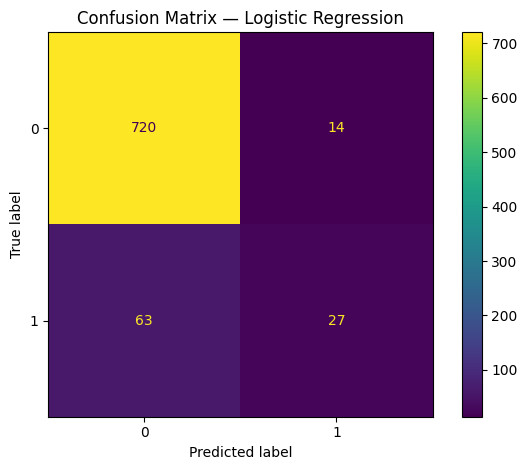

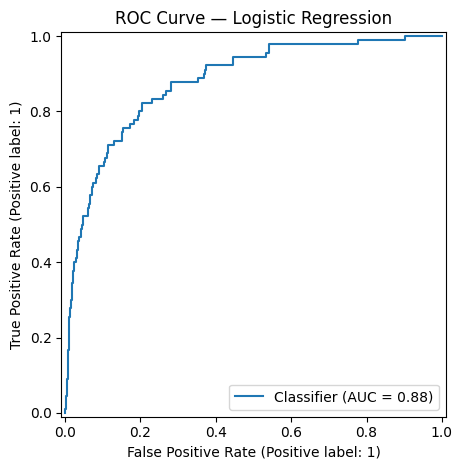


Classification report:
              precision    recall  f1-score   support

           0       0.92      0.98      0.95       734
           1       0.66      0.30      0.41        90

    accuracy                           0.91       824
   macro avg       0.79      0.64      0.68       824
weighted avg       0.89      0.91      0.89       824



In [56]:
final_model_name = tuning_results_df.loc[0, "Model"]
#final_base_name = final_model_name.replace("Tuned ", "")
final_model = log_reg

print("Selected final model:", final_model_name)

final_model.fit(X_train, y_train)
final_pred = final_model.predict(X_test)
final_proba = final_model.predict_proba(X_test)[:, 1]

ConfusionMatrixDisplay.from_predictions(y_test, final_pred, values_format="d")
plt.title(f"Confusion Matrix — {final_model_name}")
plt.tight_layout()
plt.show()

RocCurveDisplay.from_predictions(y_test, final_proba)
plt.title(f"ROC Curve — {final_model_name}")
plt.tight_layout()
plt.show()

print("\nClassification report:")
print(classification_report(y_test, final_pred, zero_division=0))

After improving the models, we found that **Logistic Regression** performs best among the ones we compared and has the best F1 score of all. Based on above **Confusion Matrix**, it predicted results with more than 90% Accuracy. 

## Project Summary and Key Findings

### Baseline & Model Performance

 - **Logistic Regression** provided a strong, interpretable baseline with competitive performance.

 - **Tuned models (Logistic Regression / SVM)** improved **F1-score**, indicating better balance between:

   - Avoiding unnecessary calls
   - Not missing high-potential customers

 - Complex models (Decision Trees) showed **overfitting**, while **KNN** struggled with scalability.

 ### Final Recommendation

 Use **Logistic Regression with class balancing** as the primary production model due to:

 - Strong performance

 - Fast training & scoring

 - High explainability for regulators and business teams

## Business Decision Outcomes & Recommendations

### 1. Smarter Campaign Training
**Prediction:**

The model can rank customers by likelihood of subscription.

**Decision:**

 - Target only the top 20–30% highest-scoring customers

 - Avoid blanket calling strategies

**Business Impact:**

 - Fewer calls

 - Higher conversion rate

 - Reduced customer annoyance

### 2. Improved Marketing ROI
**Insight:**

Accuracy alone is misleading; F1-score optimization significantly reduces wasted calls.

**Decision:**

 - Optimize campaigns using probability thresholds instead of default 0.5

 - Adjust threshold depending on campaign cost and revenue goals

**Business Impact:**

 - Lower cost per successful subscription

 - Higher campaign profitability

### 3. Agent Productivity Optimization

**Insight:**

Model predictions allow prioritization of leads.

**Decision:**

 - Assign high-probability customers to senior agents

 - Automate or deprioritize low-probability segments

**Business Impact:**

 - Better agent utilization

 - Increased subscriptions per agent

##### Questions